# Import required Libraries

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import difflib
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score


2025-05-26 18:53:26.938449: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load the Dataset

In [2]:
# Load Dataset
df = pd.read_csv("resources/SpotifyFeatures.csv")
# View basic info
df.info()  # Check column types & missing values
df.head()  # Preview first few rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


# Data Preprocessing

In [3]:
# Preprocess Data
df["mode"] = df["mode"].map({"Major": 1, "Minor": 0})  # Convert Major/Minor to numeric

# Encode artist names into numeric values
artist_encoder = LabelEncoder()
df["artist_encoded"] = artist_encoder.fit_transform(df["artist_name"])

# Select numeric features, including artist encoding
numeric_features = ["danceability", "energy", "tempo", "acousticness",
                    "instrumentalness", "valence", "loudness", "mode", "artist_encoded"]

# Sample subset for efficiency
df_sample = df.sample(5000, random_state=42).reset_index(drop=True)
df_sample.head()  # Preview sampled data

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artist_encoded
0,Country,A Thousand Horses,My Time's Comin',16zol4GvHyTER5irYODUk0,45,0.00192,0.327,194107,0.8350,0.000150,C,0.1670,-4.952,1,0.0609,171.795,4/4,0.3850,103
1,Soundtrack,Mark Mothersbaugh,House Tour,6ac5gUfGTckpdGQCyWsdh2,25,0.93200,0.253,102920,0.0798,0.568000,C,0.0906,-18.512,1,0.0439,110.931,4/4,0.0487,8228
2,Reggae,Unified Highway,We Can't Fall (Remix) [feat. J. Patz],09Yz6koF1Y15n1012t1UX6,19,0.03310,0.821,225437,0.7370,0.013400,E,0.1320,-6.295,0,0.2120,137.968,4/4,0.7870,13592
3,Electronic,Stooki Sound,Endz - Original Mix,3dzEZARDL4ZwICMKVta7Xn,29,0.00428,0.745,225400,0.7720,0.114000,E,0.0722,-3.949,1,0.0904,133.113,4/4,0.1700,11818
4,Comedy,Bill Hicks,I Love My Job (Live),39Z1G5384UgGa5vmW6WyxC,17,0.96500,0.502,287973,0.8040,0.000096,G,0.9020,-9.935,1,0.8070,104.576,3/4,0.1850,1424


# Feature Scaling

In [4]:
# Scale features
scaler = StandardScaler()
X_scaled_df = pd.DataFrame(scaler.fit_transform(df_sample[numeric_features]), columns=numeric_features)

# Apply PCA for Dimensionality Reduction

In [5]:
# Apply PCA(Principal Component Analysis) for Dimensionality Reduction
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_scaled_df)
print(f"Explained Variance Ratio: {sum(pca.explained_variance_ratio_):.2f}")  # Check variance retention

# Create DataFrame for PCA results
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7"])
pca_df["artist_name"] = df_sample["artist_name"].values
pca_df["original_index"] = df_sample.index  # Keep original index for mapping clusters
pca_df.head()  # Preview PCA DataFrame


Explained Variance Ratio: 0.95


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,artist_name,original_index
0,1.076249,1.910780,-0.160738,-2.397920,0.203782,-0.202425,-0.379842,A Thousand Horses,0
1,-3.887190,0.648977,0.688820,-0.007213,-0.109699,0.013537,0.098036,Mark Mothersbaugh,1
2,2.198608,-0.145844,-0.514408,2.012272,0.847879,-0.091408,0.170716,Unified Highway,2
3,1.337822,0.939832,0.786506,0.496775,-0.705776,-0.011333,1.569543,Stooki Sound,3
4,-0.811251,-0.344022,0.125106,-1.735560,-0.599246,-0.616428,-0.278132,Bill Hicks,4


# Apply K-Means Clustering

In [6]:
# Silhouette Score for Clustering
for k in range(2, 10):  # Avoid k=1 (single cluster isn't useful)
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans_test.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    print(f"Clusters: {k}, Silhouette Score: {score:.4f}")


Clusters: 2, Silhouette Score: 0.3146
Clusters: 3, Silhouette Score: 0.2044
Clusters: 4, Silhouette Score: 0.1978
Clusters: 5, Silhouette Score: 0.1793
Clusters: 6, Silhouette Score: 0.1662
Clusters: 7, Silhouette Score: 0.1715
Clusters: 8, Silhouette Score: 0.1748
Clusters: 9, Silhouette Score: 0.1671


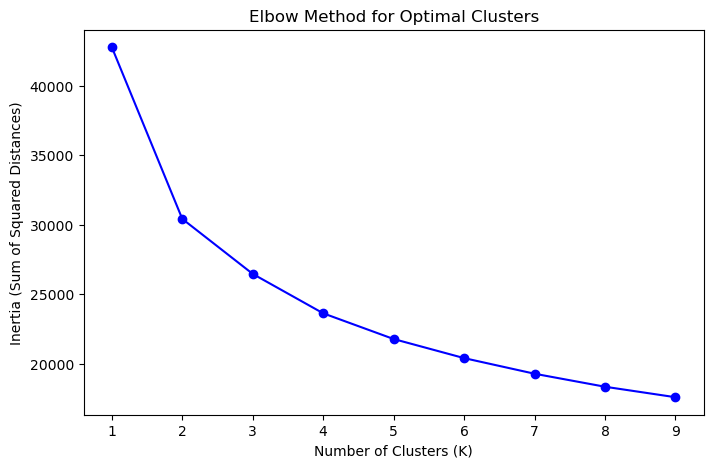

In [7]:
# Elbow Method to Determine Optimal Number of Clusters
# The Elbow Method helps to find the optimal number of clusters by plotting the inertia (sum of squared distances)
# Define range of clusters to test
num_clusters = range(1, 10)  # Testing 1 to 10 clusters
inertia_values = []

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertia_values.append(kmeans.inertia_)  # Store inertia for each cluster count

# Plot the elbow curve
plt.figure(figsize=(8,5))
plt.plot(num_clusters, inertia_values, marker="o", linestyle="-", color="blue")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal Clusters")
plt.show()


In [8]:
# Davies-Bouldin Index (DBI) is another useful metric to evaluate clustering quality.
# Compute DBI for different cluster numbers (K=2 to K=9)
for k in range(2, 10):  
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)  # Fit K-Means clustering
    dbi_score = davies_bouldin_score(X_pca, labels)  # Compute DBI
    print(f"Clusters: {k}, Davies-Bouldin Score: {dbi_score:.4f}")


Clusters: 2, Davies-Bouldin Score: 1.3413
Clusters: 3, Davies-Bouldin Score: 1.7437
Clusters: 4, Davies-Bouldin Score: 1.6970
Clusters: 5, Davies-Bouldin Score: 1.6869
Clusters: 6, Davies-Bouldin Score: 1.6023
Clusters: 7, Davies-Bouldin Score: 1.5239
Clusters: 8, Davies-Bouldin Score: 1.5963
Clusters: 9, Davies-Bouldin Score: 1.6293


In [9]:
# Perform K-Means Clustering
# Group similar songs based on their PCA-transformed features.
kmeans = KMeans(n_clusters= 2, random_state=42, n_init=10)
# 
df_sample["Cluster"] = kmeans.fit_predict(X_pca)
# Merge Cluster Labels into PCA DataFrame
pca_df["Cluster"] = df_sample.loc[pca_df["original_index"], "Cluster"].values


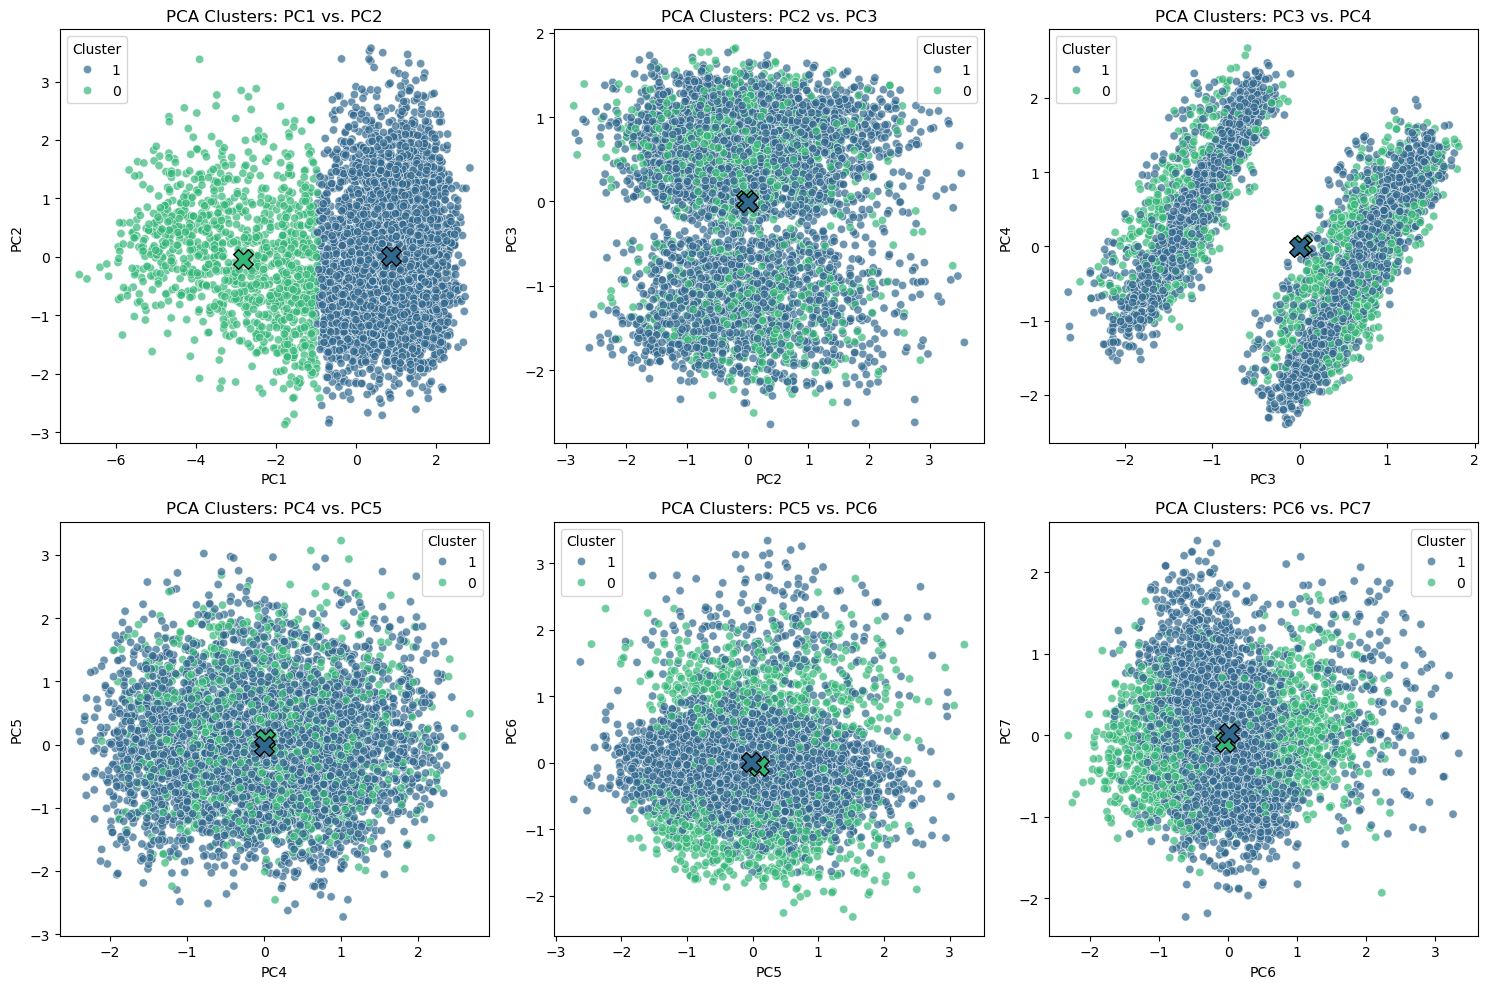

In [10]:
# Define PCA components to plot
pca_pairs = [("PC1", "PC2"), ("PC2", "PC3"), ("PC3", "PC4"), ("PC4", "PC5"), ("PC5", "PC6"), ("PC6", "PC7")]

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (pc_x, pc_y) in enumerate(pca_pairs):
    ax = axes[i]
    
    # Scatter plot of PCA clusters
    sns.scatterplot(
        x=pca_df[pc_x], 
        y=pca_df[pc_y], 
        hue=pca_df["Cluster"].astype(str), 
        palette="viridis", 
        alpha=0.7, 
        ax=ax
    )
    
    # Compute centroids
    centroids = pca_df.groupby("Cluster")[[pc_x, pc_y]].mean()
    
    # Extract cluster colors from the scatter plot
    cluster_palette = dict(zip(pca_df["Cluster"].unique(), sns.color_palette("viridis", len(pca_df["Cluster"].unique()))))

    # Plot centroids with matching cluster colors
    for cluster, row in centroids.iterrows():
        ax.scatter(row[pc_x], row[pc_y], marker="X", s=200, c=[cluster_palette[cluster]], edgecolors="black")

    ax.set_xlabel(pc_x)
    ax.set_ylabel(pc_y)
    ax.set_title(f"PCA Clusters: {pc_x} vs. {pc_y}")

plt.tight_layout()
plt.show()


/opt/anaconda3/envs/dev/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


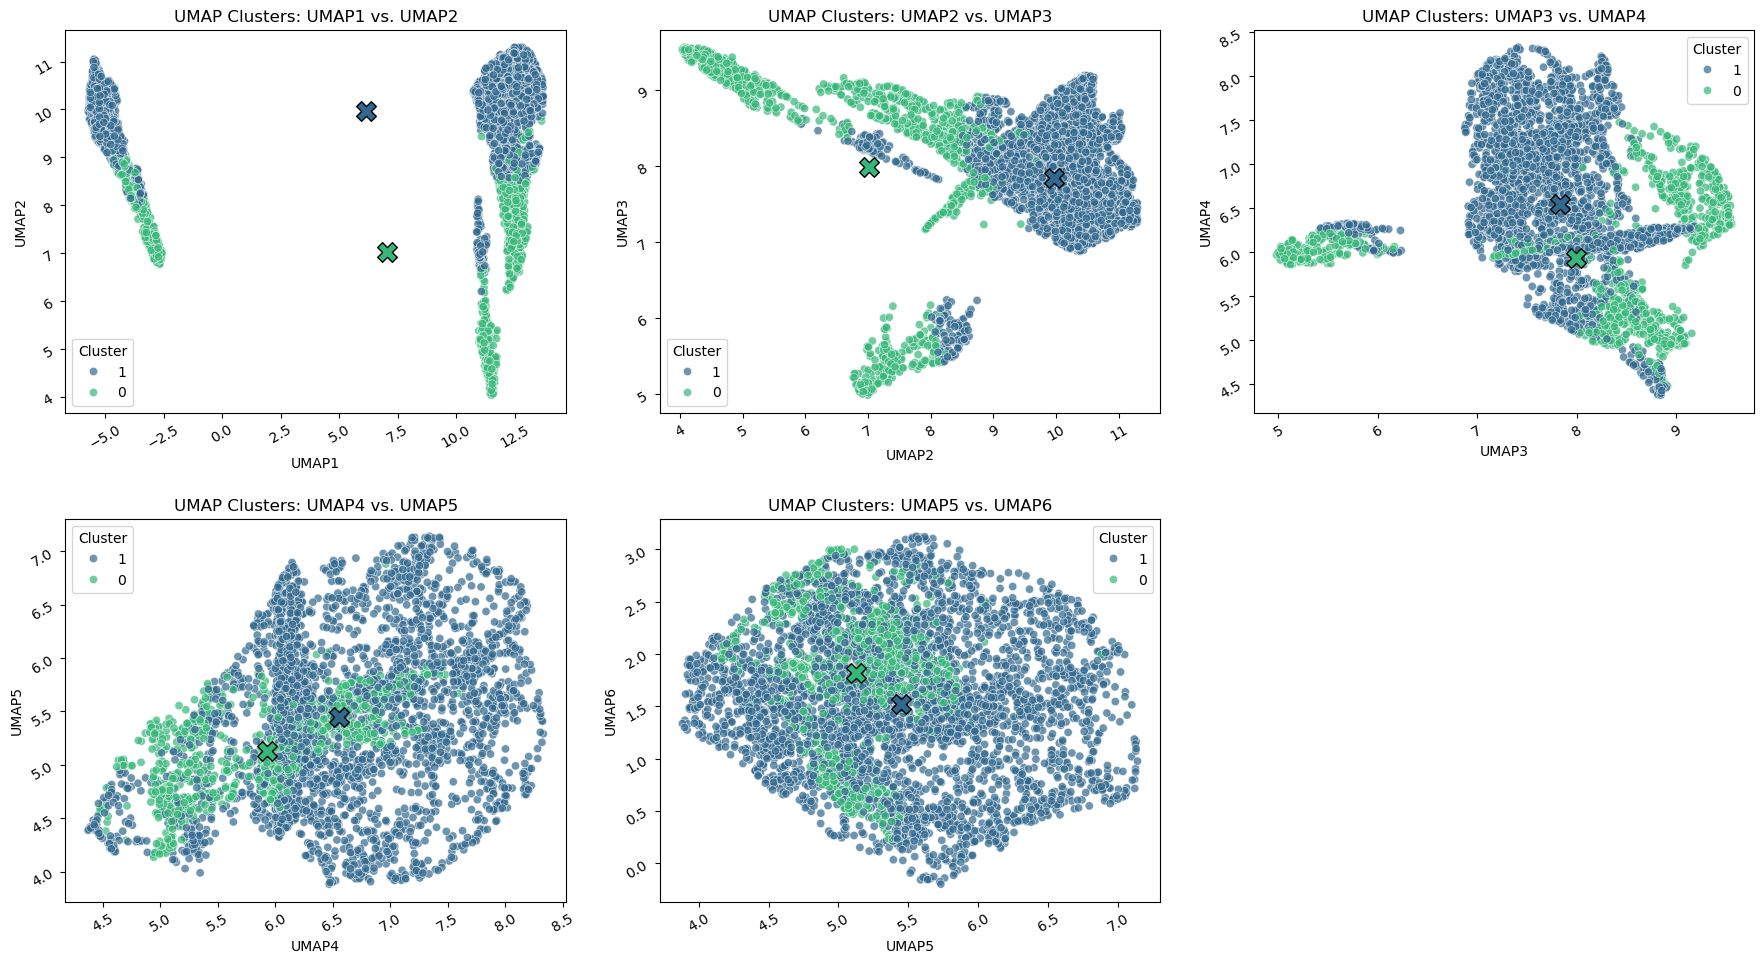

In [ ]:
# Compute UMAP embedding if not already done
umap_model = umap.UMAP(n_components=6, random_state=42)
umap_embedding = umap_model.fit_transform(X_scaled_df)

# Create DataFrame for UMAP results
umap_columns = [f"UMAP{i+1}" for i in range(umap_embedding.shape[1])]
umap_df = pd.DataFrame(umap_embedding, columns=umap_columns)
umap_df["Cluster"] = df_sample["Cluster"].values

# Define UMAP component pairs to visualize
umap_pairs = [("UMAP1", "UMAP2"), ("UMAP2", "UMAP3"), ("UMAP3", "UMAP4"), ("UMAP4", "UMAP5"), ("UMAP5", "UMAP6")]

# Create subplots dynamically based on number of pairs
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # Adjusted figure size
axes = axes.flatten()

for i, (umap_x, umap_y) in enumerate(umap_pairs):
    ax = axes[i]

    # Scatter plot of UMAP clusters
    sns.scatterplot(
        x=umap_df[umap_x], 
        y=umap_df[umap_y], 
        hue=umap_df["Cluster"].astype(str), 
        palette="viridis", 
        alpha=0.7, 
        ax=ax
    )

    # Compute centroids
    centroids = umap_df.groupby("Cluster")[[umap_x, umap_y]].mean()

    # Extract cluster colors from the scatter plot
    cluster_palette = dict(zip(umap_df["Cluster"].unique(), sns.color_palette("viridis", len(umap_df["Cluster"].unique()))))

    # Plot centroids with matching cluster colors
    for cluster, row in centroids.iterrows():
        ax.scatter(row[umap_x], row[umap_y], marker="X", s=200, c=[cluster_palette[cluster]], edgecolors="black")

    ax.set_xlabel(umap_x)
    ax.set_ylabel(umap_y)
    ax.set_title(f"UMAP Clusters: {umap_x} vs. {umap_y}")

    # Reduce overlapping text labels
    ax.tick_params(axis="x", rotation=30)
    ax.tick_params(axis="y", rotation=30)

# Remove extra empty subplot if needed
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=2.0)  # Improve spacing
plt.show()


# Song Recommendation System

In [12]:
# Normalize text (removes accents/diacritics)
def normalize_text(text):
    return unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode()

# Clean and standardize text
def clean_text(text):
    return (
        text.lower()
        .strip()
        .replace('"', '')
        .replace("'", "")
        .replace("’", "'")
        .replace(".", "")
        .replace(":", "")
        .strip()
    )

# Combined cleaning: first normalize, then clean punctuation
def full_clean_text(text):
    return clean_text(normalize_text(text))

# Load dataset
df = pd.read_csv("resources/SpotifyFeatures.csv")

# Standardize track names and artist names
df["track_name"] = df["track_name"].astype(str).apply(full_clean_text)
df["artist_name"] = df["artist_name"].astype(str).str.lower().str.strip()

def verify_song_in_data(input_song):
    """Returns DataFrame rows matching the cleaned input song."""
    cleaned_input = full_clean_text(input_song)
    return df[df["track_name"].str.contains(cleaned_input, case=False, na=False)]

def find_closest_match(input_song, cutoff=0.9, num_matches=5):
    """
    Returns multiple closest matching songs (as lists) and their artists.
    - If an exact match exists, returns it as a single-element list.
    - Otherwise, returns possible close matches.
    Duplicate song titles are filtered out.
    """
    input_song_cleaned = full_clean_text(input_song)
    all_songs = df["track_name"].dropna().tolist()
    # Remove duplicates while preserving order.
    unique_song_list = list(dict.fromkeys(all_songs))
    
    # Exact match
    if input_song_cleaned in unique_song_list:
        matched_song = input_song_cleaned
        matched_artist = df.loc[df["track_name"] == matched_song, "artist_name"].values[0]
        print(f"Exact match found: '{matched_song}' by {matched_artist}")
        return [matched_song], [matched_artist]
    
    # Get close matches from the unique list.
    closest_matches = difflib.get_close_matches(input_song_cleaned, unique_song_list, n=num_matches, cutoff=cutoff)
    if closest_matches:
        matched_songs = closest_matches
        matched_artists = [df.loc[df["track_name"] == song, "artist_name"].values[0] for song in matched_songs]
        print(f"Song '{input_song}' not found.\nPossible matches:")
        for song, artist in zip(matched_songs, matched_artists):
            print(f"- '{song}' by {artist}")
        return matched_songs, matched_artists
    else:
        print(f"No close matches found for '{input_song}'.")
        return [], []


# Recommend songs based on similarity
def recommend_song(input_song, cutoff=0.995, similarity_threshold=0.5, pre_matched=False):
    if not pre_matched:
        matched_song, matched_artist = find_closest_match(input_song, cutoff)
        if isinstance(matched_song, list) and len(matched_song) > 0:
            matched_song = matched_song[0]
            matched_artist = matched_artist[0]
        else:
            return f"Song '{input_song}' not found. Try adjusting filters or verifying spelling."
    else:
        matched_song = input_song

    numeric_features = ["danceability", "energy", "valence", "tempo", "speechiness"]
    matched_idx = df[df["track_name"] == matched_song].index
    if len(matched_idx) == 0:
        return f"Matched song '{matched_song}' not found in dataset."
    
    song_features = df.loc[matched_idx[0], numeric_features].values.reshape(1, -1)
    valid_rows = df.dropna(subset=numeric_features).index
    df_valid = df.loc[valid_rows, numeric_features]
    similarities = cosine_similarity(song_features, df_valid)
    similarity_scores = similarities[0] / similarities[0].max()
    
    df_filtered = df.loc[valid_rows].copy()
    df_filtered["Similarity"] = similarity_scores
    input_artist = df_filtered.loc[df_filtered["track_name"] == matched_song, "artist_name"].values[0]
    
    # Adjust similarity threshold dynamically based on mean similarity values
    dynamic_threshold = max(similarity_threshold, df_filtered["Similarity"].mean())
    
    recommendations = df_filtered[
        (df_filtered["artist_name"] != input_artist) & (df_filtered["Similarity"] >= dynamic_threshold)
    ]
    
    # Remove duplicate recommendations
    recommendations = recommendations.drop_duplicates(subset=["track_name", "artist_name"])

    # Apply genre filtering if genre column exists
    if "genre" in df.columns:
        input_genre = df.loc[df["track_name"] == matched_song, "genre"].values[0]
        recommendations = recommendations[recommendations["genre"] == input_genre]
    
    recommendations = recommendations.sort_values(
        by=["Similarity", "danceability", "energy"],
        ascending=[False, False, False]
    ).head(10)
    
    if recommendations.empty:
        return f"No recommendations found for '{matched_song}'. Try adjusting filters."
    
    return recommendations[["track_name", "artist_name"]]




# Test Case Handling

In [15]:
# Test case
test_song = "Koti Chennaya(Vol.1 &amp; 2)"  # Example mis-spelled song

# Get matching suggestions (exact or close matches)
matched_songs, matched_artists = find_closest_match(test_song)
if matched_songs:
    first_match = matched_songs[0]
    first_artist = matched_artists[0]
    print(f"\nUsing song: '{first_match}' by {first_artist} for recommendations.\n")
else:
    print(f"\nNo matching songs found for '{test_song}'.\n")
    first_match = test_song  # Fallback to original input

# Run the recommendation function using the first match (with pre_matched flag set to True)
recommended_songs = recommend_song(first_match, pre_matched=True)

print("Recommended songs\n")
if isinstance(recommended_songs, pd.DataFrame):
    print(recommended_songs.head())
else:
    print(recommended_songs)


Exact match found: 'koti chennaya(vol1 &amp; 2)' by chorus

Using song: 'koti chennaya(vol1 &amp; 2)' by chorus for recommendations.

Recommended songs

                                               track_name         artist_name
195964  quand le miroir reflechit (par paul ventimila,...   martin & les fées
184666             riddle, diddle, one, two, three - demo        verna felton
54361   le musee (par lorie pester, paul ventimila & v...   martin & les fées
196440                              chanson surrealiste i      henri salvador
196062                                            hercule  jean claude corbel


# Save Files

In [14]:
# Save the PCA DataFrame to CSV for further analysis
pca_df.to_csv("Output/pca_results.csv", index=False)
# Save the scaled DataFrame to CSV for further analysis
X_scaled_df.to_csv("Output/scaled_features.csv", index=False)
# Save the original DataFrame with clusters to CSV for further analysis
df_sample.to_csv("Output/original_with_clusters.csv", index=False)

# Export the recommended songs DataFrame to a CSV file, only if it's a DataFrame
if isinstance(recommended_songs, pd.DataFrame):
	recommended_songs.to_csv("Output/recommended_songs.csv", index=False)
else:
	print("No recommended songs DataFrame to save.")
